# Homework 08 — IANNwTF
## Group 27
Deadline: Dec 19, 2021 23:59

<https://forms.gle/n6ERdhYx3uBPzuGn9>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Dataset

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


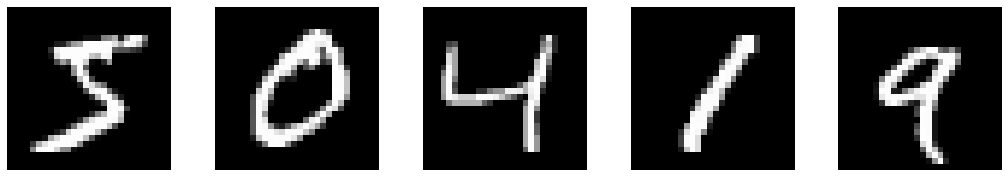

In [4]:
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(18,3))
ax = ax.ravel()
for i in range(npics):
  ax[i].imshow(X_train[i], cmap='gray')
  ax[i].axis("off")

In [5]:
# Load the dataset and construct a tf.Data.Dateset for testing and training using the images only
train_ds = tf.data.Dataset.from_tensor_slices(X_train)
test_ds = tf.data.Dataset.from_tensor_slices(X_test)

In [6]:
def prepare_data(ds):
  # convert data from uint8 to float32
  ds = ds.map(lambda img: (tf.cast(img, tf.float32)))

  # bring image values from range [0, 255] to [0, 1]
  ds = ds.map(lambda img: (img/255.))

  # add third dimension
  ds = ds.map(lambda img: tf.expand_dims(img, axis=-1))

  # Add noise to the images
  how_noisy = 0.2 # std deviation of the normal distribution
  ds = ds.map(lambda img: tf.add(img, tf.random.normal(shape=(28,28,1), mean=0.0, stddev=how_noisy, dtype=tf.dtypes.float32)))

  # make sure the images are kept in the range [0,1]
  ds = ds.map(lambda img: tf.clip_by_value(img, 0, 1))

  # shuffle, batch, prefetch
  ds = ds.shuffle(1000).batch(32).prefetch(20)
  return ds

In [7]:
train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

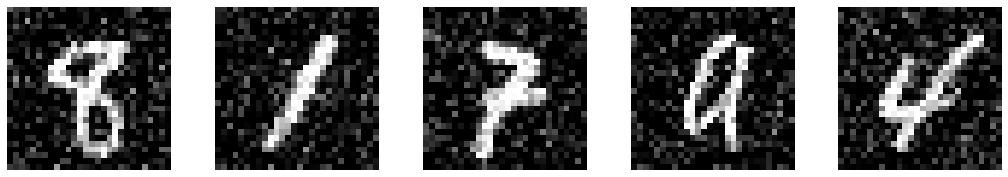

In [8]:
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(18,3))
ax = ax.ravel()
for elem, i in zip(train_ds.take(npics), range(npics)):
  ax[i].imshow(tf.squeeze(elem).numpy()[0], cmap='gray')
  ax[i].axis("off")

# Model: Convolutional Autoencoder

In [9]:
class Encoder(tf.keras.Model):
  def __init__(self, embedding_size=10):
    super(Encoder, self).__init__()
    self.layers_list = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', input_shape=((28,28,1))),
                        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(embedding_size)]
  
  def call(self, x):
    for layer in self.layers_list:
      x = layer(x)
    return x


In [10]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layers_list = [tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
                        tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')] # output layer
  
  def call(self, x):
    for layer in self.layers_list:
      x = layer(x)
    return x 


In [11]:
class Autoencoder(tf.keras.Model):
  def __init__(self, embedding_size=10):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(embedding_size)
    self.decoder = Decoder()
  
  def call(self, x):
    embedding = self.encoder(x)
    output = self.decoder(embedding)
    return output


# Training

# Latent Space Analysis